MIT License

Copyright (c) 2020 HELLA Aglaia Mobile Vision GmbH

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [1]:
import os
import sys 
from random import randint
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.patches import Rectangle
sys.path.append(os.path.abspath("../Loader"))
sys.path.append(os.path.abspath("../Converter/TFRecord"))
from OLFDetection2DTFRecord import OLFDetection2DTFRecord

In [2]:
%matplotlib inline

In [3]:
olf_dataset_tfrecord = OLFDetection2DTFRecord("../../Documents/instances_val2014_olf.json", ["image/png", "image/jpeg"], "../../../../CurrentDatasets/val2014")

OLFDetection2D: Preparing media...
OLFDetection2D: Preparing annotations...


In [4]:
olf_dataset_tfrecord.toTFRecord("../../Documents/instances_val2014_olf.tfrecord")

OLFDetection2DTFRecord: Writing tfrecord...


In [5]:
dataset = tf.data.TFRecordDataset("../../Documents/instances_val2014_olf.tfrecord")
dataset = dataset.shuffle(1000)

In [6]:
for raw_record in dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\000\360\000\360\000\000\377\342\002@ICC_PROFILE\000\001\001\000\000\0020ADBE\002\020\000\000mntrRGB XYZ \007\317\000\006\000\003\000\000\000\000\000\000acspAPPL\000\000\000\000none\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\366\326\000\001\000\000\000\000\323-ADBE\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\ncprt\000\000\000\374\000\000\0002desc\000\000\0010\000\000\000kwtpt\000\000\001\234\000\000\000\024bkpt\000\000\001\260\000\000\000\024rTRC\000\000\001\304\000\000\000\016gTRC\000\000\001\324\000\000\000\016bTRC\000\000\001\344\000\000\000\016rXYZ\000\000\001\364\000\000\000\024gXYZ\000\000\002\010\000\000\000\024bXYZ\000\000\002\034\000\000\000\024text\000\000\000\000Copyri

In [7]:
feature_description = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/source_id': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    'image/object/class/label': tf.io.VarLenFeature(tf.int64)
}

def _parse_function(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

parsed_dataset = dataset.map(_parse_function)

In [8]:
for parsed_record in parsed_dataset.take(1):
  print(repr(parsed_record))

{'image/object/bbox/xmax': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f8a86a6e9b0>, 'image/object/bbox/xmin': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f8a86a6ec50>, 'image/object/bbox/ymax': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f8a86a6ed68>, 'image/object/bbox/ymin': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f8a86a6ee10>, 'image/object/class/label': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f8a86a64eb8>, 'image/object/class/text': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f8a86a64f98>, 'image/encoded': <tf.Tensor: id=452506, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01:\x01:\x00\x00\xff\xe2\x02@ICC_PROFILE\x00\x01\x01\x00\x00\x020ADBE\x02\x10\x00\x00mntrRGB XYZ \x07\xcf\x00\x06\x00\x03\x00\x00\x00\x00\x00\x00acspAPPL\x00\x00\x00\x00none\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [9]:
height = parsed_record["image/height"].numpy()
width = parsed_record["image/width"].numpy()
xmins = parsed_record["image/object/bbox/xmin"].values.numpy()
ymins = parsed_record["image/object/bbox/ymin"].values.numpy()
xmaxs = parsed_record["image/object/bbox/xmax"].values.numpy()
ymaxs = parsed_record["image/object/bbox/ymax"].values.numpy()
clstxts = parsed_record['image/object/class/text'].values.numpy()
sample = {
    "img": tf.image.decode_jpeg(parsed_record['image/encoded']),
    "box": [[xmins[i] * width, ymins[i] * height, xmaxs[i] * width, ymaxs[i] * height] for i in range(len(xmins))],
    "cls": [cls.decode('utf-8') for cls in clstxts]
}

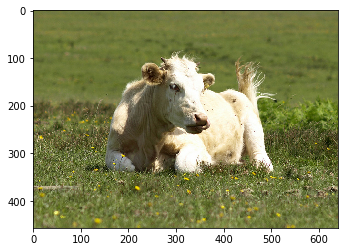

In [10]:
plt.imshow(sample["img"])

In [11]:
sample["box"]

[[155.600004196167, 82.29999740421772, 514.739990234375, 344.55999851226807]]

In [12]:
sample["cls"]

['cow']

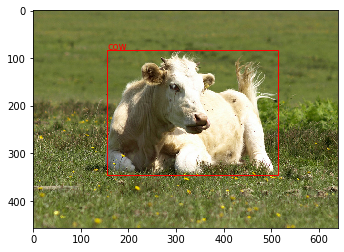

In [13]:
assert len(sample["box"]) == len(sample["cls"])

fig,ax = plt.subplots(1)
ax.imshow(sample["img"])
for i, box in enumerate(sample["box"]):
    ax.add_patch(Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth = 1, edgecolor = 'r', facecolor = 'none'))
    plt.text(box[0], box[1], sample["cls"][i], color = 'r')
plt.show()